In [1]:
import tensorflow as tf
import os
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(1)
random.seed(1)

In [2]:
PATH ='./data/dogs-vs-cats/'

train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

In [3]:
train_len = len(os.listdir(train_dir))
valid_len = len(os.listdir(valid_dir))
test_len = len(os.listdir(test_dir))

In [4]:
print('total training images:', train_len)
print('total validation images:', valid_len)
print('total testing images:', test_len)

total training images: 20000
total validation images: 5000
total testing images: 12500


In [5]:
CLASS_NAMES = ["cat", "dog"]

EPOCH_SIZE = 5
BATCH_SIZE = 32
BUFFER_SIZE= BATCH_SIZE * 5
STEPS_PER_EPOCH = train_len//BATCH_SIZE
VALIDATION_STEPS = valid_len//BATCH_SIZE
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [6]:
def process_label(path):
    label = tf.strings.split(path, os.path.sep)[-1]
    label = tf.strings.split(label, ".")[0]
    return tf.cast(label == CLASS_NAMES, tf.float32)

def process_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])

def scale_image(image):
    return tf.image.per_image_standardization(image)

def process_data(path):
    image = process_image(path)
    image = scale_image(image)
    label = process_label(path)
    
    return image, label

def input_fn(path):
    list_ds = tf.data.Dataset.list_files(str(path))
    return list_ds \
        .map(process_data) \
        .shuffle(BUFFER_SIZE) \
        .batch(BATCH_SIZE) \
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE) \
        .repeat(EPOCH_SIZE)

In [7]:
train_ds = input_fn(os.path.join(train_dir, "*.jpg")).take(5000)
valid_ds = input_fn(os.path.join(valid_dir, "*.jpg")).take(2000)

W0424 21:42:57.245887 140735961576320 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [8]:
def model_fn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.MaxPool2D(strides=2),
        tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'),
        tf.keras.layers.MaxPool2D(strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.optimizers.Adam(lr=5e-4),
                  loss=tf.losses.CategoricalCrossentropy(), 
                  metrics=["accuracy"])
    
    return model

In [9]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               11059456  
_________________________________________________________________
dense_1 (Dense)              (None, 84)                2

In [10]:
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    validation_steps=int(2000 / BATCH_SIZE),
                    epochs = EPOCH_SIZE, 
                    steps_per_epoch = int(5000 / BATCH_SIZE), 
                    use_multiprocessing=True, 
                    workers=7)

Train for 156 steps, validate for 62 steps
Epoch 1/5
156/156 [==============================] - 78s 499ms/step - loss: 0.6915 - accuracy: 0.5903 - val_loss: 0.6248 - val_accuracy: 0.6356
Epoch 2/5
156/156 [==============================] - 77s 495ms/step - loss: 0.6059 - accuracy: 0.6599 - val_loss: 0.5953 - val_accuracy: 0.6472
Epoch 3/5
156/156 [==============================] - 76s 488ms/step - loss: 0.5705 - accuracy: 0.7021 - val_loss: 0.5442 - val_accuracy: 0.7314
Epoch 4/5
156/156 [==============================] - 82s 526ms/step - loss: 0.5189 - accuracy: 0.7410 - val_loss: 0.5114 - val_accuracy: 0.7389
Epoch 5/5
156/156 [==============================] - 81s 521ms/step - loss: 0.4570 - accuracy: 0.7786 - val_loss: 0.6269 - val_accuracy: 0.7041


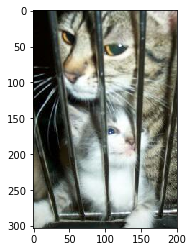

'dog'

In [39]:
def predict(path, plot_img = False):
    if plot_img:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img)
        plt.imshow(img)
        plt.show()
        
    img = next(iter(process_data(path)))
    x = np.expand_dims(img, axis=0)
    classes = model.predict(x)
    return "cat" if np.argmax(classes) == 0 else "dog"

predict(os.path.join(test_dir, os.listdir(test_dir)[1]), True)